# #01 - Explaining TEDA Forecasting

## 1. Modules import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Importing our modules:

In [2]:
from teda import TEDA
from RLSFilter import RLSFilter

from treating import dataTreating, dataSpliting, dataProcessing, dataSplit

In [3]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

## 2. Data managing

### 2.1 Power data:

In [4]:
data = pd.read_csv("Electric_Production.csv")
data.rename(columns={'DATE':'Date', 'IPG2211A2N':'Production'}, inplace=True)
data.head()

#Variables
series = "Production"
date = "Date"

### 2.2 Inserting outliers:

In [5]:
data['label'] = 0

In [6]:
outliers_percentage = 8/100

#Outliers do tipo zero
#z = o[0:np.round(len(o)/2).astype(int)]
z = [61,37,287,230,214,162,98,30,278,28,25,314,348,195,113,387]

#Outliers do tipo pico
#p = o[np.round(len(o)/2).astype(int): -1]
p = [125,242,291,377,34,206,249,118,389,12,376,375,74,146,272,368]

#### Peak-type outliers will have **twice** the magnitude. Therefore:

In [7]:
data['Outlier'] = data[series]

data['Outlier'].iloc[p] = 1.5*data[series].iloc[p]
data['label'].iloc[p] = 1

c:\Users\Samsung\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Zero-type outliers has value equals **zero**:

In [8]:
data['Outlier'].iloc[z] = 0
data['label'].iloc[z] = 1

### Let's see the new curve:

In [9]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Dataset with outliers"
)

figure.add_trace(
    go.Scatter(y=data['Outlier'], name='With Outliers'),
    secondary_y=False
)

figure.update_xaxes(title='Time (months)')
figure.update_yaxes(title='Eletric Production', secondary_y=False)
figure.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


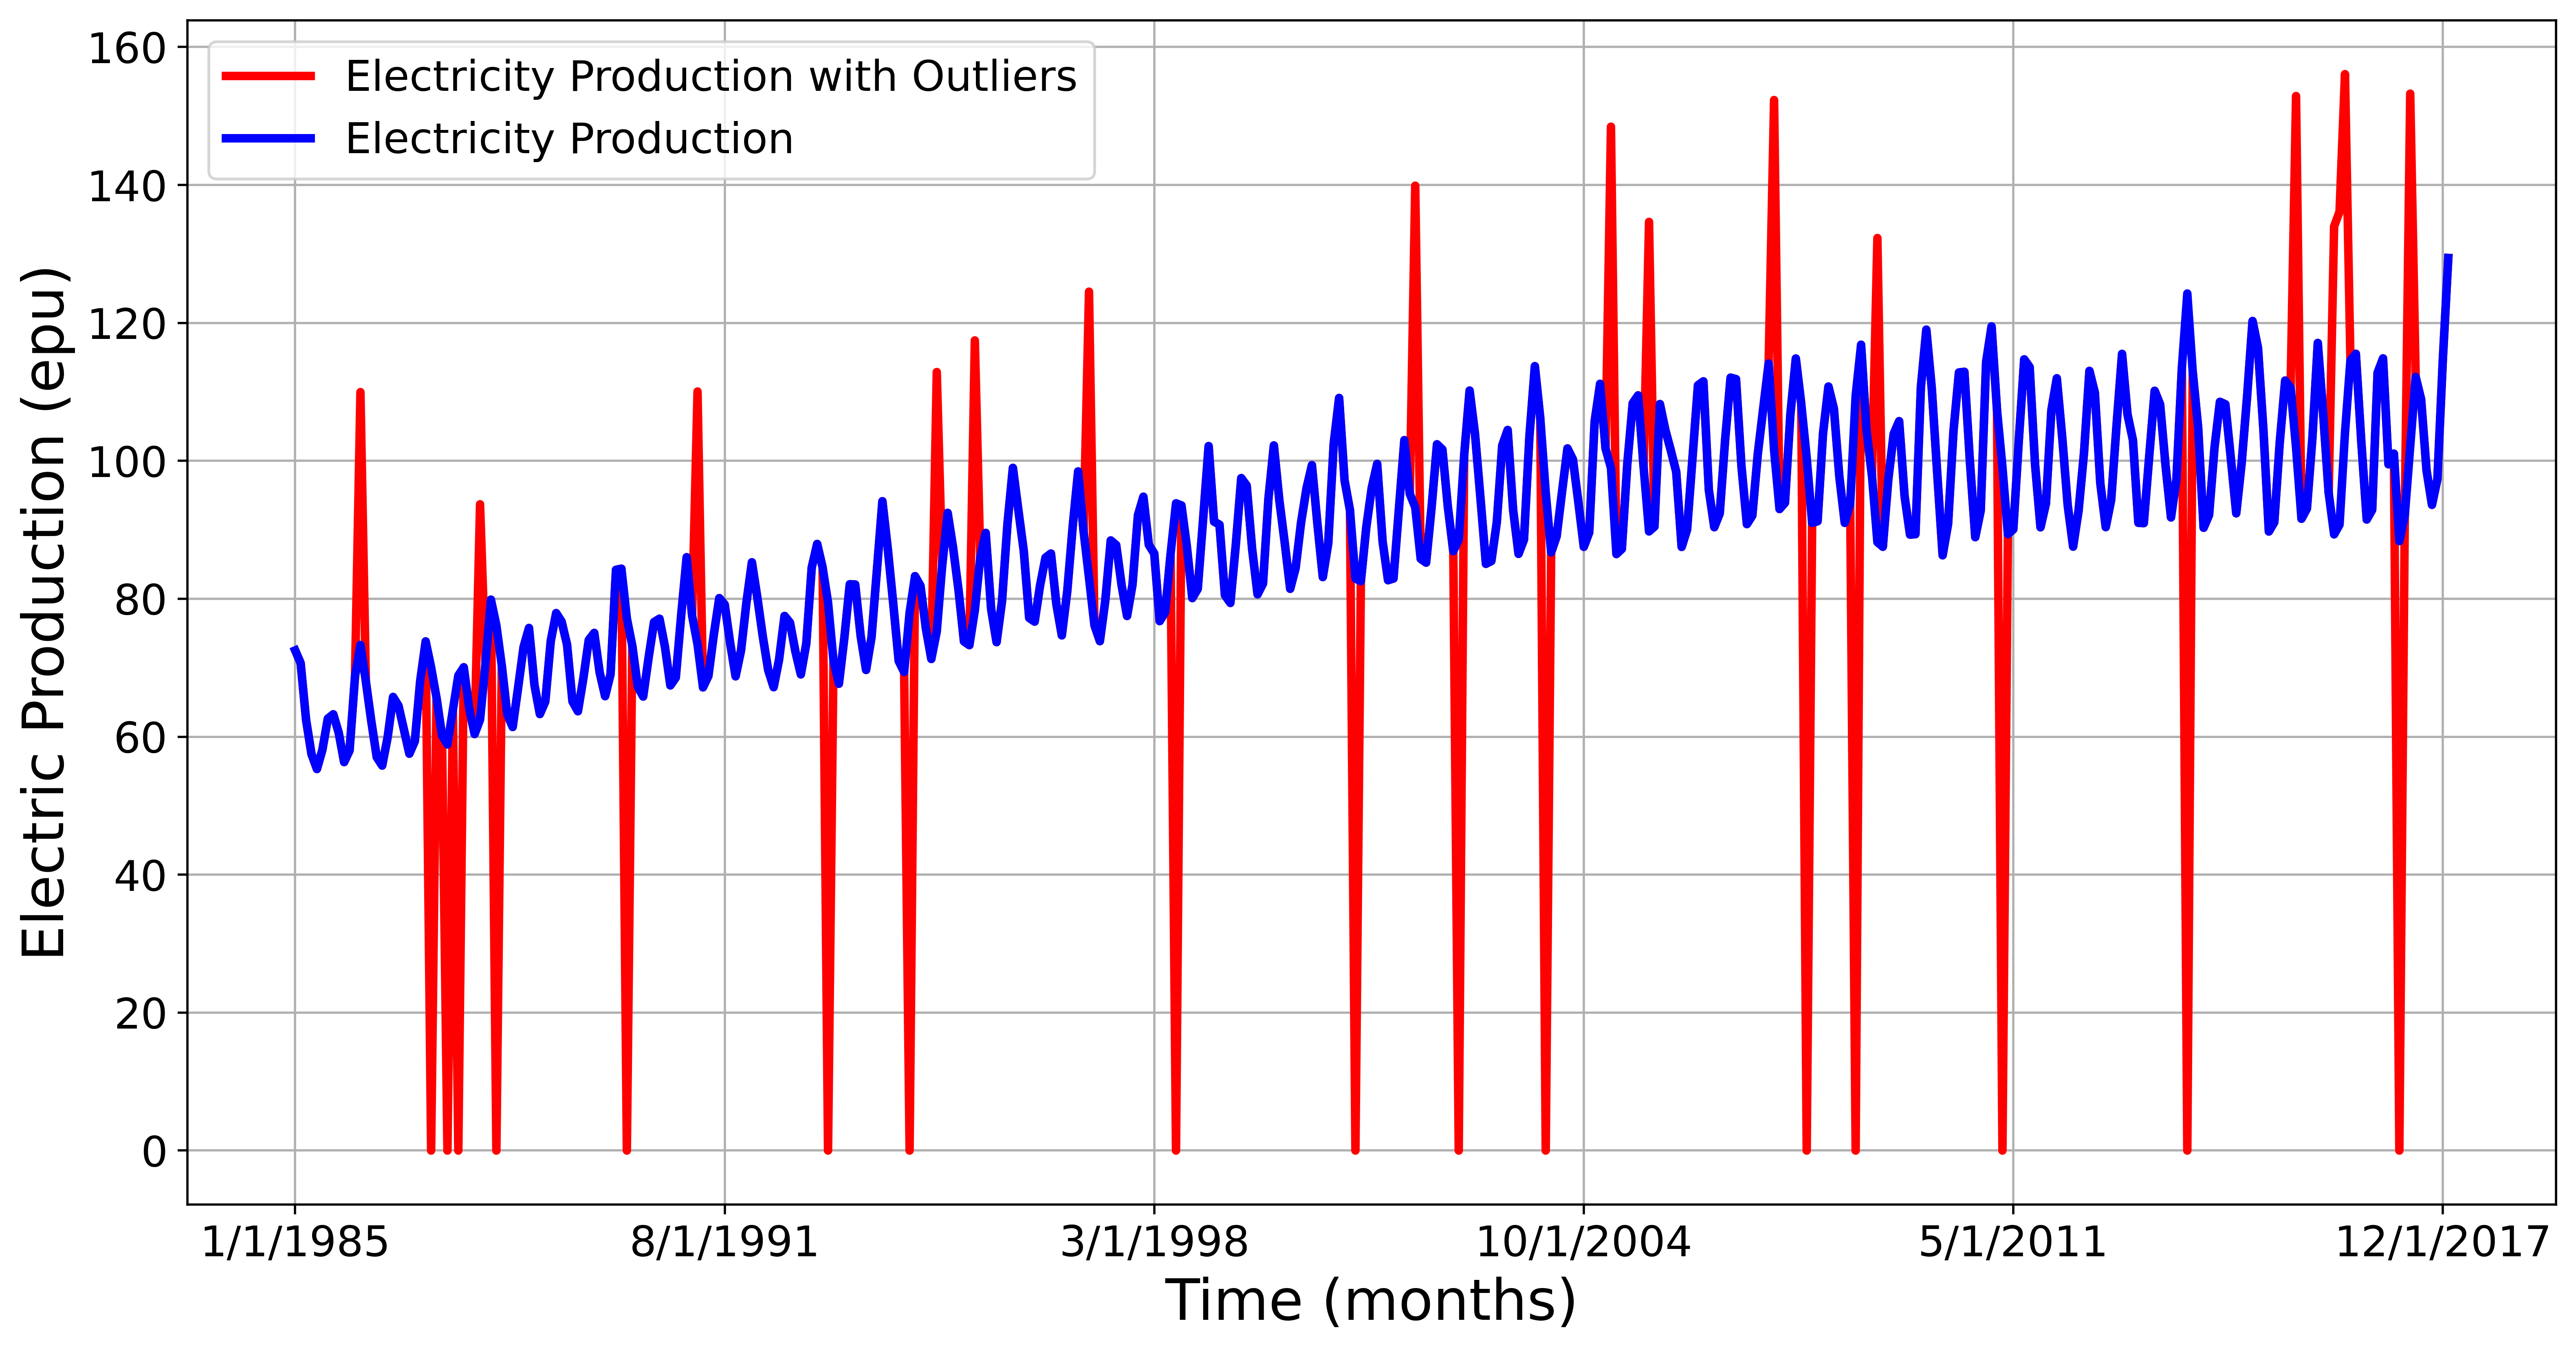

In [27]:
plt.figure(figsize=(15,7.7), dpi=500)
plt.xticks(fontsize=15)
plt.xticks(np.arange(0, len(data)+1, np.round(len(data)/5)))
plt.yticks(fontsize=15)
plt.grid()

plt.xlabel("Time (months)", fontsize=20)
plt.ylabel("Electric Production (epu)", fontsize=20)
plt.plot(data['Date'], data['Outlier'], 'r', label='Electricity Production with Outliers', linewidth=3)
plt.plot(data['Date'], data['Production'], 'b', label='Electricity Production', linewidth=3)
plt.legend(fontsize=15)

#plt.savefig('eletric_production_dataset.eps', format='eps', bbox_inches='tight')

# 3. Running TEDA-Forecasting

In [10]:
RMSE_full = []
MAE_full = []

window = 2
forecasting = 2

# Data processing
df, df_train, df_test, X_train, y_train, X_test, y_test = dataSplit(data["Outlier"], data["label"], window=window, forecasting=forecasting, N_splits=4)

# Labels Index
labelsIndex = find_indices(df_test['label'], 1)
ts = np.linspace(0, len(df_test), len(df_test))

#TEDA
teda = TEDA(threshold=2)
N_outlier_max = 3    # Consecutive outlier correction flagN_outlier_max   # Maximum of outliers corrected by TEDAForecasting
correction = True    # Consecutive outlier correction flag

FLAG = []

#RLS
filter_order = window                           # Filter_order equivalent to window size
w0 = np.zeros(filter_order).tolist()            # Initial weights
X_ant = np.zeros(filter_order).tolist()         # Initial previous input
rls_filter = RLSFilter(n = window, mu = 0.99, delta=0.1, w=w0) #Defining the filter instance

Ya_py = []          # Vector of auxiliary predicted values
Y_py = []           # Vector of predicted values
Y_v = []            # Vector of virtual predicted values
DB = []             # Vector of saved values (database)
outlier_count = 0   # Outlier count 
y_pred_py = 0.0     # Initial predicted value   

for i in df_test['x(t)']:
    ## Acquiring the data input
    valor_atual = i

    #Checking if it is an outlier
    flag = teda.run(valor_atual)
    FLAG.append(flag)

    ## First Stage: Correcting outlier
    if (flag == 1):       
        outlier_count = outlier_count + 1
        valor_atual = y_pred_py
    else:
        outlier_count = 0
    
    #Evaluating the flood of outliers
    if(correction == True and outlier_count == N_outlier_max + 1):
        valor_atual = i
    
    #Saving 
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))

    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    #Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    # Creating virtual inputs
    virtual_input = input_vector[1:]
    virtual_input.append(y_pred_py)

    # Creating virtual filter
    w_virtual = []
    for x in rls_filter.w:
        w_virtual.append(x)
    virtual_filter = RLSFilter(n = filter_order, mu = 0.99, delta=0.1, w=w_virtual) #Defining the filter instance
    virtual_filter.update(y_pred_py, np.array(input_vector))


    for l in range(1, forecasting):
        #Predicting the next value
        y_pred_virtual = virtual_filter.filter(virtual_input)
        virtual_filter.update(y_pred_virtual, np.array(virtual_input))
        Y_v.append(y_pred_virtual)

        virtual_input = virtual_input[1:]
        virtual_input.append(y_pred_virtual)
    
    # Second stage
    if (flag == 1):
        valor_atual = y_pred_py

    if(correction == True and outlier_count == N_outlier_max + 1):
        outlier_count = 0
        valor_atual = i
    DB.append(valor_atual)

    #Updating previous values vector
    X_ant = input_vector


df_test['flag_py'] = FLAG
df_test['save_py'] = DB
df_test['ya_pred_py'] = Ya_py
df_test['y_pred_py'] = Y_py

### Creating the forecasting dataframe:
Y_v = np.array(Y_v).reshape(len(df_test),(forecasting-1))

df_y_forecasting_columns = []
for i in range(1, forecasting+1):
    df_y_forecasting_columns.append('y(t+' + str(i) + ')')

df_Y_v = pd.DataFrame(data=Y_v)
df_Y_v.insert(loc=0, column=df_y_forecasting_columns[0], value=Y_py, allow_duplicates=True)
df_Y_v.set_axis(df_y_forecasting_columns, axis=1, inplace=True)

numberOfOutliersPython = df_test['flag_py'].sum()
outliersIndexPython = find_indices(df_test['flag_py'], 1)

# TEDA Metrics:
f1 = f1_score(df_test['label'], df_test['flag_py'])
accuracy = accuracy_score(df_test['label'], df_test['flag_py'])
recall = recall_score(df_test['label'], df_test['flag_py'])

# Forecasting
RMSE = []
for i in range(0, forecasting):
    rmse = mean_squared_error(y_test[0:-1, i], df_Y_v.iloc[1:, i].values, squared=False)
    RMSE.append(rmse)
rmse_pred = mean_squared_error(y_test[0:-1, 0], df_Y_v.iloc[1:, 0].values, squared=False)
RMSE_full.append(RMSE)
RMSE_mean = np.mean(RMSE)
RMSE_max = np.max(RMSE)
RMSE_min = np.min(RMSE)
RMSE_std = np.std(RMSE)

MAE = []
for i in range(0, forecasting):
    mae = mean_absolute_error(y_test[0:-1, i], df_Y_v.iloc[1:, i].values)
    MAE.append(mae)
mae_pred = mean_absolute_error(y_test[0:-1, 0], df_Y_v.iloc[1:, 0].values)
MAE_full.append(MAE)
MAE_mean = np.mean(MAE)
MAE_max = np.max(MAE)
MAE_min = np.min(MAE)
MAE_std = np.std(MAE)


# Visualization

In [15]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Dataset with outliers"
)

figure.add_trace(
    go.Scatter(y=y_test[0:-1, 0], name='Production With Outliers'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=df_Y_v.iloc[1:, 0].values, name='TEDA'),
    secondary_y=False
)


figure.update_xaxes(title='Time (months)')
figure.update_yaxes(title='Eletric Production', secondary_y=False)
figure.show()